In [107]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal , Uniform
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import NUTS, MCMC
from pyro.optim import Adam
from TaylorF2_hack import TaylorF2

# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
n_points = 200
Mf_max = 1.0/(6**(3.0/2.0) * np.pi) # cut at ISCO
Mf_array = np.linspace(1e-3, Mf_max, n_points) # Geometric frequency
Mf0 = 0.01
A0 =1.
params = [5. , 10. , 0. , 0.] ## (m1 , m2 , chi1 , chi2)

In [121]:
# pn = TaylorF2(*params)
# strain = pn.only_compute_strain()
# plt.figure()
# plt.plot(Mf_array , strain.numpy() , label = 'waveform')
# plt.xlabel('f')
# plt.ylabel('h(f)')
# plt.legend()

In [122]:
m1 = torch.tensor(10.)
m2 = torch.tensor(5.)
chi1 = torch.tensor(0.)
chi2 = torch.tensor(0.)
params = [m1 , m2 , chi1 , chi2]

In [135]:
pn = TaylorF2(*params)
data = pn.only_compute_strain()
noise = 1/5* torch.randn((len(data),))
data = data + noise.double()

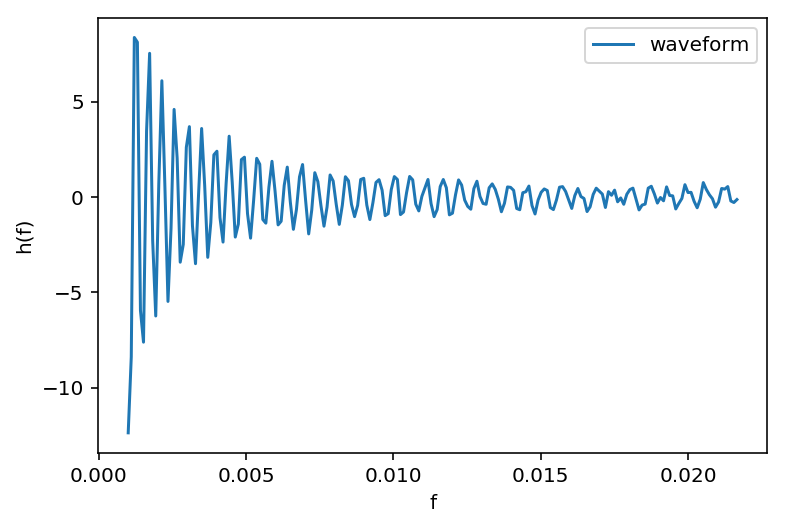

In [136]:
plt.figure()
plt.plot(Mf_array , data.numpy() , label = 'waveform')
plt.xlabel('f')
plt.ylabel('h(f)')
plt.legend()

In [132]:
def model(data):
    m1_prior = pyro.sample("m1", Uniform(low = torch.tensor(0.), high=torch.tensor(100.)))
    m2_prior = pyro.sample("m2", Uniform(low = torch.tensor(0.), high=torch.tensor(100.)))
    chi1_prior = pyro.sample('chi1' , Uniform(low = torch.tensor(-1.), high =torch.tensor(1.)))
    chi2_prior = pyro.sample('chi2' ,Uniform(low = torch.tensor(-1.), high =torch.tensor(1.)))
    s2_prior = pyro.sample("variance", Normal(loc=torch.zeros(1), scale=torch.ones(1)))
    params = [m1_prior , m2_prior , chi1_prior , chi2_prior]
    pn = TaylorF2(*params)
    strain = pn.only_compute_strain()
    likelihood = pyro.sample("yhat", Normal(loc = strain , scale=s2_est), obs=data)
    return likelihood

In [131]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=400).run(data)

ValueError: The parameter scale has invalid values